# Notebook 5: (Demo) Cloning method for DPK convolution

Method published at (DOI) to reduce the number of slices needed for autoradiography-based DPK dosimetry.

Inputs: 
- iQID activity image (or images)
- Simulated MC dose kernel
- FoV measurement (scale information) of iQID pixel sizes

Output:
- Central-slice dose-rate image

In [1]:
# Move the working directory up one level to the one shown to find the source packages.
# Feel free to modify your own system path to accomodate this package if desired.
# Please note this change for all relative paths contained in the notebook.

In [2]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\dev_iqid_alphas


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '18'

from matplotlib.colors import LogNorm
from scipy.ndimage import convolve
from skimage import io, util
from importlib import reload

from iqid import dpk, process
reload(dpk)

<module 'iqid.dpk' from 'C:\\Users\\Robin\\Documents\\Cal\\iQID\\dev_iqid_alphas\\iqid\\dpk.py'>

## Test module with a simple 1-D array to visualize the method
Purely for demonstration purposes: say you start with a 1-dimensional "stack" of ten numbers, 0 through 9. Then, the cloning method can be visualized by using each number to represent which slices are used in the operation.

In [4]:
# little test module to demonstrate the method in 1D
a = np.arange(9)
print('Nine "slices" numbered 0-9:')
print(a)
print('')
print('')

for j in range(len(a)//2 + len(a)%2):
    num_slices = 2*j+len(a)%2
    idx = len(a)//2
    toleft = num_slices//2
    toright = num_slices//2
    
    print('Preserving slices {} to {} and duplicating outwards'.format(idx-toleft, idx+toright))
    
    duped_stack = np.copy(a)
    duped_stack[:(idx-toleft)] = a[idx-toleft]
    duped_stack[(idx+toright):] = a[idx+toright]
    print(duped_stack)
    print('')

Nine "slices" numbered 0-9:
[0 1 2 3 4 5 6 7 8]


Preserving slices 4 to 4 and duplicating outwards
[4 4 4 4 4 4 4 4 4]

Preserving slices 3 to 5 and duplicating outwards
[3 3 3 3 4 5 5 5 5]

Preserving slices 2 to 6 and duplicating outwards
[2 2 2 3 4 5 6 6 6]

Preserving slices 1 to 7 and duplicating outwards
[1 1 2 3 4 5 6 7 7]

Preserving slices 0 to 8 and duplicating outwards
[0 1 2 3 4 5 6 7 8]



In the two extremes, only the center slice is used (e.g., a one-slice measurement), or all slices are used (same as the conventional full-sequence method).

## iQID cloning method using one slice only

In [5]:
imdir = os.path.join('data', 'H700', '25March')

In [6]:
param_dir = os.path.join('parameters')
kern_id = 'at211_10E6_151_1um_water.txt'
scale_id = 'scale_data.csv'
act_corr = 'activity_correction.csv'

# Load the dose kernel (MeV) and bin it to the field-of-view scale.
print('Loading Geant4 kernel...')

# Load in the Geant4 kernel and average radially.
dose_kernel = dpk.load_kernel(os.path.join(param_dir, kern_id),
                                dim=151, num_alpha_decays=10e6)
radial_kernel = dpk.radial_avg_kernel(dose_kernel, mode='whole')

# Import the field-of-view data and select our sample study from the list.
# Subpx is the factor used to subpixelate (interpolate) the listmode data.
px, mm, subpx = np.genfromtxt(os.path.join(param_dir, scale_id),
                            delimiter=',', skip_header=1,
                            usecols=(1,2,3), unpack=True)

a_diff = np.genfromtxt(os.path.join(param_dir, act_corr),
                            delimiter=',', skip_header=1,
                            usecols=(2))

a_corr = a_diff/100

# Pad the kernel up to integer multiples of the voxel size.
um_per_px = mm/px * 1e3 / subpx

eff_4pi = 4.25/4.32
eff_2pi = 0.5*eff_4pi
efficiency_factor = 1/eff_2pi
time_snapshot = 1  # second

Loading Geant4 kernel...


In [7]:
num_slices = 5 # number of slices to pad on either side
study_idx = 2

    doing full convolution...
    doing cloning convolution...


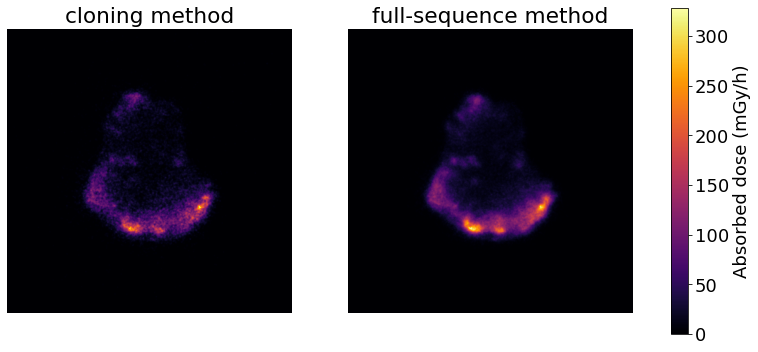

In [8]:
# correct for error introduced by alignment
astack_mBq = io.imread(os.path.join(imdir, 'aligned', 'imstack.tif'))
astack_corr = astack_mBq / (1+a_corr[study_idx])
events = astack_corr * efficiency_factor * time_snapshot * 1e-3 # convert mBq > Bq

# kernel padding and binning
study_um_px = np.round(um_per_px[study_idx])
study_slice_z = 12
padded_kernel = dpk.pad_kernel_to_vsize(radial_kernel,
                                            vox_xy=study_um_px,
                                            slice_z=study_slice_z)
vox_vol_m = (study_um_px * 1e-6)**2 * (study_slice_z * 1e-6)

# Bin the kernel down to match the iQID image resolution.
d, m, n = padded_kernel.shape
binned_kernel = process.bin_ndarray(padded_kernel,
                                    (int(d/study_slice_z),
                                    int(m/study_um_px),
                                    int(n/study_um_px)))
mgy_kernel = dpk.mev_to_mgy(binned_kernel, vox_vol_m)

print('    doing full convolution...')
# Unit conversions and convolution.
mgy_per_hr = convolve(events, mgy_kernel) * 60 * 60
full_center = mgy_per_hr[len(mgy_per_hr)//2,:,:]

print('    doing cloning convolution...')
# Pad up and perform convolution
events = astack_corr * efficiency_factor * time_snapshot * 1e-3 # convert mBq > Bq
base_image = events[len(events)//2,:,:]
w,h = np.shape(base_image)
duped_stack = np.repeat(base_image[np.newaxis, :, :], num_slices, axis=0)
mgy_per_hr = convolve(duped_stack, mgy_kernel) * 60 * 60
central_slice = mgy_per_hr[len(mgy_per_hr)//2,:,:]

# Visualization
fig, ax = plt.subplots(1,2, figsize=(14,6))
im = ax[1].imshow(full_center, cmap='inferno', vmin=np.min(full_center), vmax=np.max(full_center))
ax[0].imshow(central_slice, cmap='inferno', vmin=np.min(full_center), vmax=np.max(full_center))
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('cloning method')
ax[1].set_title('full-sequence method')

cbar= fig.colorbar(im, ax=ax.ravel().tolist())
cbar.set_label('Absorbed dose (mGy/h)')
plt.show()

To use multiple slices but still apply cloning (e.g., three measured slices), please combine the test module shown above with the framework here. We may update this tutorial in the future to show it explicitly.